https://understat.readthedocs.io/en/latest/classes/understat.html#the-functions

In [2]:
!pip install understat
!pip install nest-asyncio
!pip install fpl
!pip install --upgrade fpl

import nest_asyncio
nest_asyncio.apply()
import numpy as np
import asyncio
import json
import pandas as pd
import aiohttp
from understat import Understat



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: pytest
    Found existing installation: pytest 7.4.4
    Uninstalling pytest-7.4.4:
      Successfully uninstalled pytest-7.4.4
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 3.3.2
    Uninstalling charset-normalizer-3.3.2:
      Successfully uninstalled charset-normalizer-3.3.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.3
    Uninstalling beautifulsoup4-4.12.3:
      Successfully uninstalled beautifulsoup4-4.12.3
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.9.3
    Uninstalling aiohttp-3.9.3:
      Successfully unin

In [3]:
# Variables
season = 2024
selectedTeam='Chelsea'
selectedTeamLeague=''

In [4]:
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        leagues = await understat.get_stats()
        df_leagues=pd.DataFrame(leagues)
        df_leagues=df_leagues['league'].unique()

        all_league_teams=[]
        all_league_players=[]

        for league in df_leagues:
          player = await understat.get_league_players(league, season)
          all_league_players+=player
          team = await understat.get_league_table(league,season)
          team[0].append('League')
          for i in team[1:]:
            i.append(league)
          all_league_teams+=team


        df_allplayers = pd.read_json(json.dumps(all_league_players))
        print(df_allplayers.max())
        df_allplayers.to_csv('allLeaguesPlayerData.csv')

        df_allteams = pd.read_json(json.dumps(all_league_teams))
        df_allteams.columns = df_allteams.iloc[0]
        df_allteams=df_allteams.drop(df_allteams.index[0])
        df_allteams = df_allteams.drop(df_allteams[df_allteams['Team'] == 'Team'].index)
        df_allteams['shots']=np.nan
        df_allteams['shotsA']=np.nan


        for team in df_allteams['Team']:
          team_stats = await understat.get_team_stats(team,season)
          dfts = pd.read_json(json.dumps(team_stats))
          dfts.drop(dfts.iloc[:,0:6], axis=1, inplace=True)
          dfts = dfts.iloc[-5:]
          shots=0
          shotsA=0

          for j in dfts.result:
            shots+=j['shots']
            shotsA+=j['against']['shots']
          index = df_allteams.index[df_allteams['Team'] == team].tolist()
          df_allteams['G'][index]=df_allteams['G'][index]/df_allteams['M'][index]
          df_allteams['GA'][index]=df_allteams['GA'][index]/df_allteams['M'][index]
          df_allteams['PTS'][index]=df_allteams['PTS'][index]/df_allteams['M'][index]
          df_allteams['xG'][index]=df_allteams['xG'][index]/df_allteams['M'][index]
          df_allteams['xGA'][index]=df_allteams['xGA'][index]/df_allteams['M'][index]
          df_allteams['NPxG'][index]=df_allteams['NPxG'][index]/df_allteams['M'][index]
          df_allteams['NPxGA'][index]=df_allteams['NPxGA'][index]/df_allteams['M'][index]
          df_allteams['xPTS'][index]=df_allteams['xPTS'][index]/df_allteams['M'][index]
          df_allteams['shots'][index]=shots/df_allteams['M'][index]
          df_allteams['shotsA'][index]=shotsA/df_allteams['M'][index]

        df_allteams.to_csv('allLeaguesAllTeams.csv')

        selectedTeamLeague=df_allteams.loc[df_allteams['Team']==selectedTeam].League.values[0]

        selected_team_data = await understat.get_team_players(selectedTeam, season)
        dftd = pd.read_json(json.dumps(selected_team_data))
        dftd.to_csv('selectedTeamPlayers.csv')

        current_league_table = df_allteams[df_allteams.League==selectedTeamLeague]
        current_league_table.to_csv('currentLeagueTable.csv')



loop = asyncio.get_event_loop()
loop.run_until_complete(main())

id                             12413
player_name             Ørjan Nyland
games                             23
time                            2070
goals                             24
xG                         18.847552
assists                           11
xA                         10.750426
shots                             94
key_passes                        66
yellow_cards                      13
red_cards                          2
position                           S
team_title      Zenit St. Petersburg
npg                               21
npxG                       16.574221
xGChain                    25.598131
xGBuildup                  17.123714
dtype: object


<ipython-input-4-4a3b6e51a424>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allteams['G'][index]=df_allteams['G'][index]/df_allteams['M'][index]
<ipython-input-4-4a3b6e51a424>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allteams['GA'][index]=df_allteams['GA'][index]/df_allteams['M'][index]
<ipython-input-4-4a3b6e51a424>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allteams['PTS'][index]=df_allteams['PTS'][index

 **Creat a csv file that has data from league table of the current year and 2 best years of selected team**

In [7]:
# Joseph Gomez
async def main():
  async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        leagues = await understat.get_stats()
        dd=pd.DataFrame(leagues)
        dd=dd['league'].unique()
        top_teams=[]
        dfs=[]
        for i in dd:
          league_teams = await understat.get_league_table(i,season)
          dflt = pd.read_json(json.dumps(league_teams))
          dflt.columns = dflt.iloc[0]
          dflt=dflt.drop(dflt.index[0])
          dflt.drop(['NPxGD','PPDA','OPPDA','DC','ODC'], axis=1, inplace=True)
          dflt['shots']=np.nan
          dflt['sum_ga_xga']=dflt['GA']+dflt['xGA'] if i!='EPL' else (dflt['GA']+dflt['xGA'])*0.8
          dflt['shotsA']=np.nan
          dflt.sort_values(by=['sum_ga_xga'], inplace=True)
          dflt = dflt.iloc[0:3]
          for k in dflt['Team']:
            if(k!=selectedTeam):
              team_stats = await understat.get_team_stats(k,season)
              dfts = pd.read_json(json.dumps(team_stats))
              dfts.drop(dfts.iloc[:,0:6], axis=1, inplace=True)
              dfts = dfts.iloc[-5:]
              shots=0
              shotsA=0
              for j in dfts.result:
                shots+=j['shots']
                shotsA+=j['against']['shots']
              index = dflt.index[dflt['Team'] == k].tolist()
              dflt['G'][index]=dflt['G'][index]/dflt['M'][index]
              dflt['GA'][index]=dflt['GA'][index]/dflt['M'][index]
              dflt['PTS'][index]=dflt['PTS'][index]/dflt['M'][index]
              dflt['xG'][index]=dflt['xG'][index]/dflt['M'][index]
              dflt['xGA'][index]=dflt['xGA'][index]/dflt['M'][index]
              dflt['NPxG'][index]=dflt['NPxG'][index]/dflt['M'][index]
              dflt['NPxGA'][index]=dflt['NPxGA'][index]/dflt['M'][index]
              dflt['xPTS'][index]=dflt['xPTS'][index]/dflt['M'][index]
              dflt['sum_ga_xga'][index]=dflt['sum_ga_xga'][index]/dflt['M'][index]
              dflt['shots'][index]=shots/dflt['M'][index]
              dflt['shotsA'][index]=shotsA/dflt['M'][index]
          dfs.append(dflt)
        result = pd.concat(dfs)
        result.sort_values(by=['sum_ga_xga'], inplace=True)
        result=result.iloc[0:5]
        result.to_csv('allLeagues.csv')
        all_players=[]
        for i in result['Team']:
          team_players = await understat.get_team_players(i,season)
          dftp=pd.read_json(json.dumps(team_players))
          dftp=dftp[dftp.position.str.contains('D')]
          dftp.sort_values(by=['games'],ascending=False, inplace=True)
          dftp=dftp.iloc[0:3]
          all_players.append(dftp)
        defensive_players=pd.concat(all_players)
        defensive_players['card_penalty']=defensive_players['yellow_cards']+3*defensive_players['red_cards']
        defensive_players.sort_values(by=['card_penalty'],inplace=True)
        defensive_players=defensive_players.iloc[0:10]
        defensive_players.to_csv('bestDefensivePlayers.csv')


loop = asyncio.get_event_loop()
loop.run_until_complete(main())

In [8]:
# Pablo Rosario
async def main():
  async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        leagues = await understat.get_stats()
        dd=pd.DataFrame(leagues)
        dd=dd['league'].unique()
        array=[]
        top_teams=[]
        # print(dd)
        dfs=[]
        for i in dd:
          league_teams = await understat.get_league_table(i,season)
          dflt = pd.read_json(json.dumps(league_teams))
          dflt.columns = dflt.iloc[0]
          dflt=dflt.drop(dflt.index[0])
          dflt.drop(['NPxGD','PPDA','OPPDA','DC','ODC'], axis=1, inplace=True)
          dflt['shots']=np.nan
          dflt['sum_ga_xga']=dflt['GA']+dflt['xGA'] if i!='EPL' else (dflt['GA']+dflt['xGA'])*0.8
          dflt['shotsA']=np.nan
          dflt.sort_values(by=['sum_ga_xga'], inplace=True)
          dflt = dflt.iloc[0:3]
          for k in dflt['Team']:
            if(k!=selectedTeam):
              team_stats = await understat.get_team_stats(k,season)
              dfts = pd.read_json(json.dumps(team_stats))
              dfts.drop(dfts.iloc[:,0:6], axis=1, inplace=True)
              dfts = dfts.iloc[-5:]
              shots=0
              shotsA=0
              for j in dfts.result:
                shots+=j['shots']
                shotsA+=j['against']['shots']
              index = dflt.index[dflt['Team'] == k].tolist()
              dflt['G'][index]=dflt['G'][index]/dflt['M'][index]
              dflt['GA'][index]=dflt['GA'][index]/dflt['M'][index]
              dflt['PTS'][index]=dflt['PTS'][index]/dflt['M'][index]
              dflt['xG'][index]=dflt['xG'][index]/dflt['M'][index]
              dflt['xGA'][index]=dflt['xGA'][index]/dflt['M'][index]
              dflt['NPxG'][index]=dflt['NPxG'][index]/dflt['M'][index]
              dflt['NPxGA'][index]=dflt['NPxGA'][index]/dflt['M'][index]
              dflt['xPTS'][index]=dflt['xPTS'][index]/dflt['M'][index]
              dflt['sum_ga_xga'][index]=dflt['sum_ga_xga'][index]/dflt['M'][index]
              dflt['shots'][index]=shots/dflt['M'][index]
              dflt['shotsA'][index]=shotsA/dflt['M'][index]
            # print(dflt)
          dfs.append(dflt)
        result = pd.concat(dfs)
        result.sort_values(by=['sum_ga_xga'], inplace=True)
        result=result.iloc[0:5]
        result.to_csv('allLeagues.csv')
        all_players=[]
        for i in result['Team']:
          team_players = await understat.get_team_players(i,season)
          dftp=pd.read_json(json.dumps(team_players))
          dftp=dftp[dftp.position.str.contains('M')]
          dftp.sort_values(by=['games'],ascending=False, inplace=True)
          dftp=dftp.iloc[0:3]
          all_players.append(dftp)
        defensive_players=pd.concat(all_players)
        defensive_players['card_penalty']=defensive_players['yellow_cards']+3*defensive_players['red_cards']
        defensive_players.sort_values(by=['card_penalty'],inplace=True)
        defensive_players.to_csv('bestMidFielderPlayers.csv')





loop = asyncio.get_event_loop()
loop.run_until_complete(main())

In [9]:
season = 2024
selectedTeam='Chelsea'

async def main():
  async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        leagues = await understat.get_stats()
        dd=pd.DataFrame(leagues)
        dd=dd['league'].unique()
        array=[]
        top_teams=[]
        # print(dd)
        dfs=[]
        for i in dd:
          league_teams = await understat.get_league_table(i,season)
          dflt = pd.read_json(json.dumps(league_teams))
          dflt.columns = dflt.iloc[0]
          dflt=dflt.drop(dflt.index[0])
          dflt.drop(['NPxGD','PPDA','OPPDA','DC','ODC'], axis=1, inplace=True)
          dflt['shots']=np.nan
          dflt['sum_ga_xga']=dflt['GA']+dflt['xGA'] if i!='EPL' else (dflt['GA']+dflt['xGA'])*0.8
          dflt['shotsA']=np.nan
          dflt.sort_values(by=['sum_ga_xga'], inplace=True)
          dflt = dflt.iloc[0:3]
          for k in dflt['Team']:
            if(k!=selectedTeam):
              team_stats = await understat.get_team_stats(k,season)
              dfts = pd.read_json(json.dumps(team_stats))
              dfts.drop(dfts.iloc[:,0:6], axis=1, inplace=True)
              dfts = dfts.iloc[-5:]
              shots=0
              shotsA=0
              for j in dfts.result:
                shots+=j['shots']
                shotsA+=j['against']['shots']
              index = dflt.index[dflt['Team'] == k].tolist()
              dflt['G'][index]=dflt['G'][index]/dflt['M'][index]
              dflt['GA'][index]=dflt['GA'][index]/dflt['M'][index]
              dflt['PTS'][index]=dflt['PTS'][index]/dflt['M'][index]
              dflt['xG'][index]=dflt['xG'][index]/dflt['M'][index]
              dflt['xGA'][index]=dflt['xGA'][index]/dflt['M'][index]
              dflt['NPxG'][index]=dflt['NPxG'][index]/dflt['M'][index]
              dflt['NPxGA'][index]=dflt['NPxGA'][index]/dflt['M'][index]
              dflt['xPTS'][index]=dflt['xPTS'][index]/dflt['M'][index]
              dflt['sum_ga_xga'][index]=dflt['sum_ga_xga'][index]/dflt['M'][index]
              dflt['shots'][index]=shots/dflt['M'][index]
              dflt['shotsA'][index]=shotsA/dflt['M'][index]
            # print(dflt)
          dfs.append(dflt)
        result = pd.concat(dfs)
        result.sort_values(by=['sum_ga_xga'], inplace=True)
        result=result.iloc[0:5]
        result.to_csv('allLeagues.csv')
        all_players=[]
        for i in result['Team']:
          team_players = await understat.get_team_players(i,season)
          dftp=pd.read_json(json.dumps(team_players))
          dftp=dftp[dftp.position.str.contains('GK')]
          dftp.sort_values(by=['games'],ascending=False, inplace=True)
          dftp=dftp.iloc[0:3]
          all_players.append(dftp)
        defensive_players=pd.concat(all_players)
        defensive_players.sort_values(by=['time'],ascending=False,inplace=True)
        defensive_players.to_csv('bestGKPlayers.csv')





loop = asyncio.get_event_loop()
loop.run_until_complete(main())

In [10]:
season = 2024
selectedTeam='Chelsea'

async def main():
  async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        leagues = await understat.get_stats()
        dd=pd.DataFrame(leagues)
        dd=dd['league'].unique()
        array=[]
        top_teams=[]
        # print(dd)
        dfs=[]
        for i in dd:
          league_teams = await understat.get_league_table(i,season)
          dflt = pd.read_json(json.dumps(league_teams))
          dflt.columns = dflt.iloc[0]
          dflt=dflt.drop(dflt.index[0])
          dflt.drop(['NPxGD','PPDA','OPPDA','DC','ODC'], axis=1, inplace=True)
          dflt['shots']=np.nan
          dflt['sum_g_xg']=dflt['G']+dflt['xG'] if i!='EPL' else (dflt['G']+dflt['xG'])*1.2
          dflt['shotsA']=np.nan
          dflt.sort_values(by=['sum_g_xg'],ascending=False, inplace=True)
          dflt = dflt.iloc[0:4]
          for k in dflt['Team']:
            if(k!=selectedTeam):
              team_stats = await understat.get_team_stats(k,season)
              dfts = pd.read_json(json.dumps(team_stats))
              dfts.drop(dfts.iloc[:,0:6], axis=1, inplace=True)
              dfts = dfts.iloc[-5:]
              shots=0
              shotsA=0
              for j in dfts.result:
                shots+=j['shots']
                shotsA+=j['against']['shots']
              index = dflt.index[dflt['Team'] == k].tolist()
              dflt['G'][index]=dflt['G'][index]/dflt['M'][index]
              dflt['GA'][index]=dflt['GA'][index]/dflt['M'][index]
              dflt['PTS'][index]=dflt['PTS'][index]/dflt['M'][index]
              dflt['xG'][index]=dflt['xG'][index]/dflt['M'][index]
              dflt['xGA'][index]=dflt['xGA'][index]/dflt['M'][index]
              dflt['NPxG'][index]=dflt['NPxG'][index]/dflt['M'][index]
              dflt['NPxGA'][index]=dflt['NPxGA'][index]/dflt['M'][index]
              dflt['xPTS'][index]=dflt['xPTS'][index]/dflt['M'][index]
              dflt['sum_g_xg'][index]=dflt['sum_g_xg'][index]/dflt['M'][index]
              dflt['shots'][index]=shots/dflt['M'][index]
              dflt['shotsA'][index]=shotsA/dflt['M'][index]
            # print(dflt)
          dfs.append(dflt)
        result = pd.concat(dfs)
        result.sort_values(by=['sum_g_xg'],ascending=False, inplace=True)
        result=result.iloc[0:5]
        result.to_csv('allLeagues.csv')
        all_players=[]
        for i in result['Team']:
          team_players = await understat.get_team_players(i,season)
          dftp=pd.read_json(json.dumps(team_players))
          dftp=dftp[dftp.position.str.contains('M')]
          dftp['sum_a_xa']=dftp['assists']+dftp['xA']
          dftp.sort_values(by=['sum_a_xa'],ascending=False, inplace=True)
          dftp=dftp.iloc[0:3]
          all_players.append(dftp)
        defensive_players=pd.concat(all_players)
        defensive_players.sort_values(by=['sum_a_xa'],ascending=False,inplace=True)
        defensive_players.to_csv('bestMidFieldAndForwardPlayers.csv')


loop = asyncio.get_event_loop()
loop.run_until_complete(main())


In [11]:
async def main():
  async with aiohttp.ClientSession() as session:
        understat = Understat(session)

        df_read_allteams = pd.read_csv('allLeaguesAllTeams.csv')
        df_read_allteams.drop(df_read_allteams.iloc[:,0:1], axis=1, inplace=True)

        for row in df_read_allteams:
          print(row)

        result = df_read_allteams
        result = df_read_allteams.iloc[0:5]
        result.drop(result.iloc[:,0:1], axis=1, inplace=True)

        result.to_csv('defenceList.csv')

loop = asyncio.get_event_loop()
loop.run_until_complete(main())

Team
M
W
D
L
G
GA
PTS
xG
NPxG
xGA
NPxGA
NPxGD
PPDA
OPPDA
DC
ODC
xPTS
League
shots
shotsA


<ipython-input-11-cc43c016b9b5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.drop(result.iloc[:,0:1], axis=1, inplace=True)


In [12]:
!pip install mplsoccer
from mplsoccer.pitch import Pitch
from mplsoccer.pitch import VerticalPitch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 2.5 MB/s eta 0:00:00


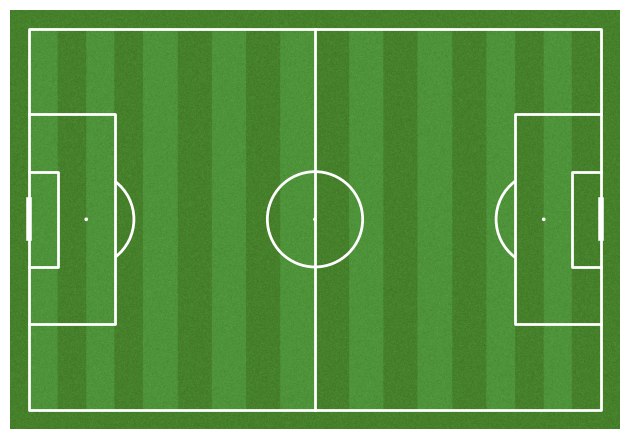

In [13]:
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw()

In [16]:
!pip install mplsoccer
from mplsoccer import Radar, FontManager, grid
import matplotlib.pyplot as plt


[5, 4.982234204187989, 8, 6.8999078422784805, 43, 48]
[5, 5.865220725536346, 3, 3.692453084513545, 34, 22]


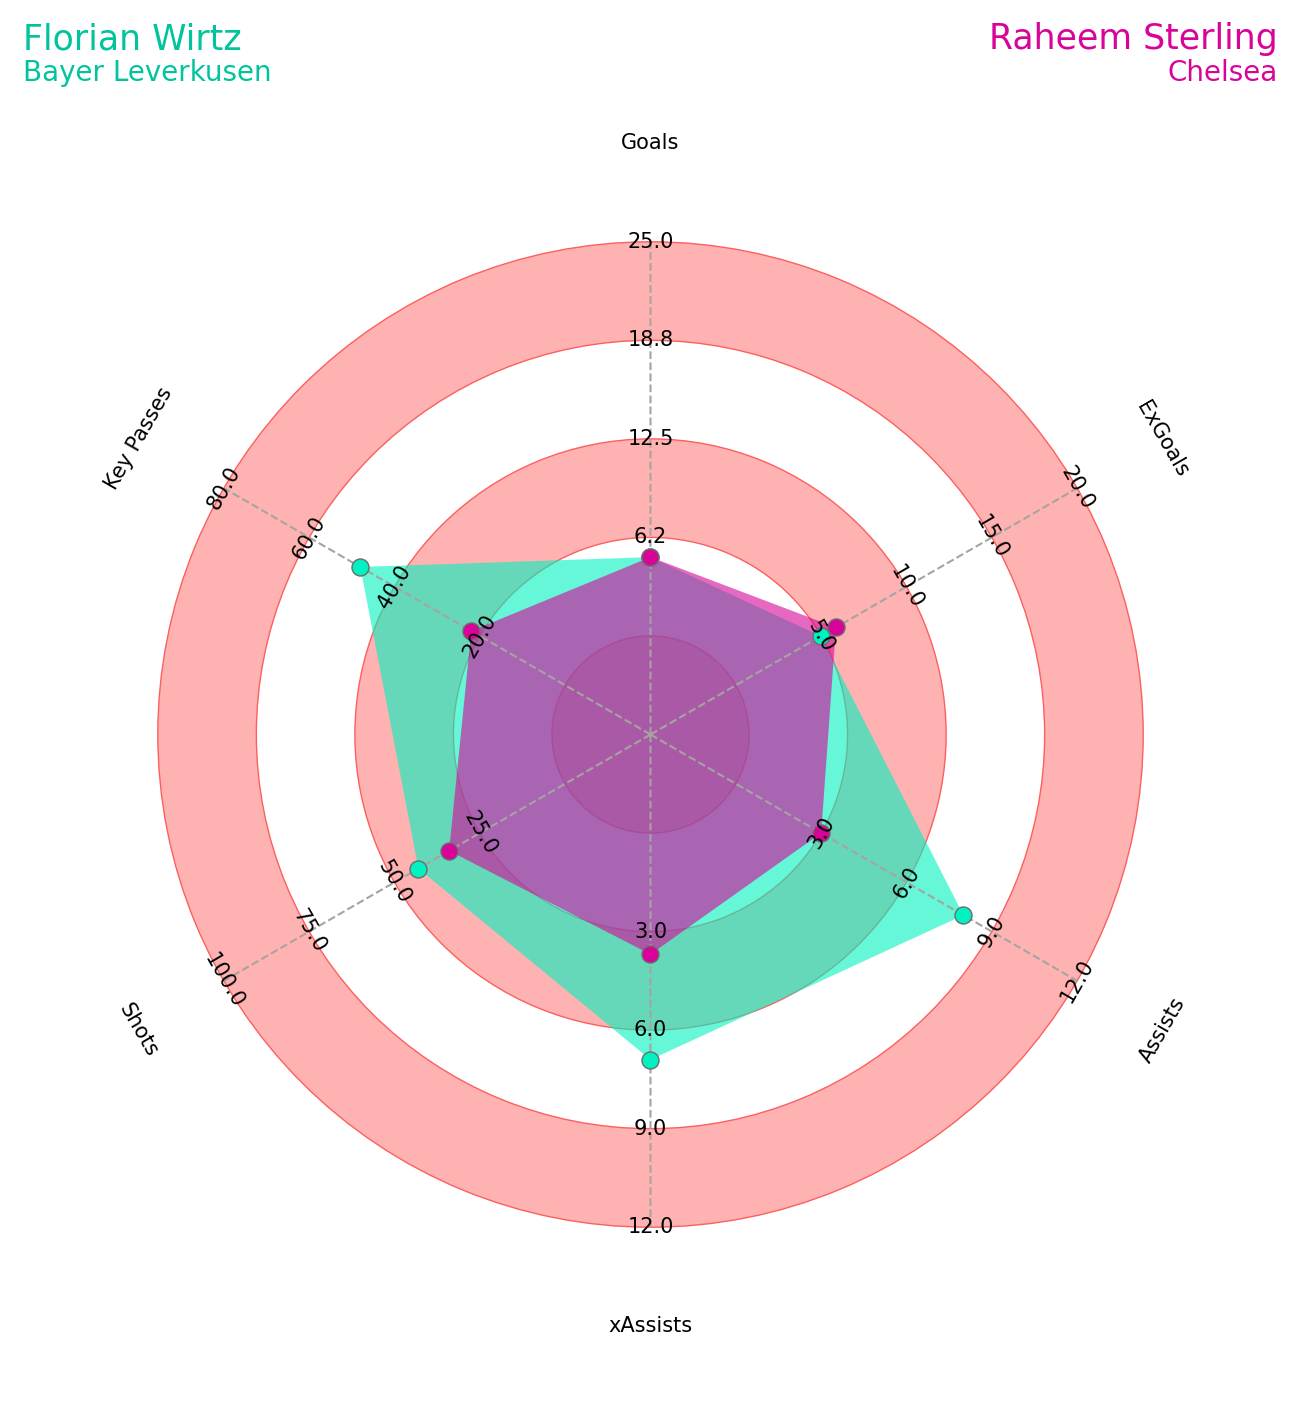

In [17]:
async def main():
  async with aiohttp.ClientSession() as session:
        understat = Understat(session)

        def function(id1,id2):

          params = ["Goals", "ExGoals","Assists", "xAssists", "Shots", "Key Passes"]
          low =  [0, 0, 0, 0, 0,  0]
          high = [25, 20, 12, 12, 100, 80]
          f = pd.read_csv("allLeaguesPlayerData.csv")
          df_player=f.loc[f['id']==id1]
          df_player2=f.loc[f['id']==id2]
          values=[df_player['goals'].values[0],df_player['xG'].values[0],df_player['assists'].values[0],df_player['xA'].values[0],df_player['shots'].values[0],df_player['key_passes'].values[0]]
          values2=[df_player2['goals'].values[0],df_player2['xG'].values[0],df_player2['assists'].values[0],df_player2['xA'].values[0],df_player2['shots'].values[0],df_player2['key_passes'].values[0]]

          print(values)
          print(values2)
          radar = Radar(params, low, high,
                round_int=[False]*len(params),
                num_rings=4,
                ring_width=1, center_circle_radius=1)
          fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)
          radar.setup_axis(ax=axs['radar'])  # format axis as a radar
          rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#fc5f5f')
          radar_output = radar.draw_radar_compare(values, values2, ax=axs['radar'],
                                        kwargs_radar={'facecolor': '#00f2c1', 'alpha': 0.6},
                                        kwargs_compare={'facecolor': '#d80499', 'alpha': 0.6})
          radar_poly, radar_poly2, vertices1, vertices2 = radar_output
          range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=15)
          param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=15)
          lines = radar.spoke(ax=axs['radar'], color='#a6a4a1', linestyle='--', zorder=2)
          axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
                     c='#00f2c1', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)
          axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
                              c='#d80499', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)

          title1_text = axs['title'].text(0.01, 0.65, df_player['player_name'].values[0], fontsize=25, color='#01c49d', ha='left', va='center')
          title2_text = axs['title'].text(0.01, 0.25, df_player['team_title'].values[0], fontsize=20, ha='left', va='center', color='#01c49d')
          title3_text = axs['title'].text(0.99, 0.65, df_player2['player_name'].values[0], fontsize=25, ha='right', va='center', color='#d80499')
          title4_text = axs['title'].text(0.99, 0.25, df_player2['team_title'].values[0], fontsize=20, ha='right', va='center', color='#d80499')
        function(8397,618)
loop = asyncio.get_event_loop()
loop.run_until_complete(main())
